In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from scipy.integrate import odeint, solve_ivp, complex_ode
import scipy.constants as cons
import scipy.linalg as la
from qutip import *

from sympy import *
from sympy.solvers.solveset import linsolve
init_printing(use_unicode=True) # pretty printing

# Rabi Oscillations in Two Level System

## 1. Steady State Solution

The condition p11 + p22 = 0 holds


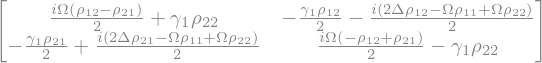

In [2]:
# Symbol definitions for density matrix components
rho11, rho12, rho21, rho22 = symbols('rho11 rho12 rho21 rho22')
Delta = symbols('Delta')

# Symbol definitions for Hamiltonian components
Omega = symbols('Omega')
hbar = symbols('hbar')

# Symbol definitions for Lindbladian components
gamma1 = symbols('gamma_1')

p = Matrix([[rho11, rho12], [rho21, rho22]]) # Density Matrix

H_AL = hbar/2 * Matrix([[Delta, Omega], [Omega, -Delta]])

# Atomic Transition Operators
p11 = Matrix([[1, 0], [0, 0]])
p22 = Matrix([[0, 0], [0, 1]])
p12 = Matrix([[0, 1], [0, 0]])
p21 = Matrix([[0, 0], [1, 0]])

# Lidbladian Components
L21 = gamma1 * ((p12 * p * p21) - (p22 * p)/2 - (p * p22)/2)

# Lindbladian
L = L21

# Lindbladian Master Equation
liouville = -(I/hbar) * ((H_AL * p) - (p * H_AL))
obe = liouville + L

cond = obe[0] + obe[3]

if simplify(cond) == 0:
    print("The condition p11 + p22 = 0 holds")
else:
    print("Conndition does not hold")

simplify(obe)
#simplify(H_AL)

In [3]:
eqns = [obe[0], obe[3], obe[1], obe[2], Eq(rho11 + rho22, 1)]
vars = [rho11, rho12, rho21, rho22]
solst = solve(eqns, vars, rational=False)
solsts = list(solst.values())

l = []
for expr in solsts:
    f = lambdify([Delta, Omega, gamma1], expr, "numpy")
    l.append(f)

Stored 'rho12' (ndarray)


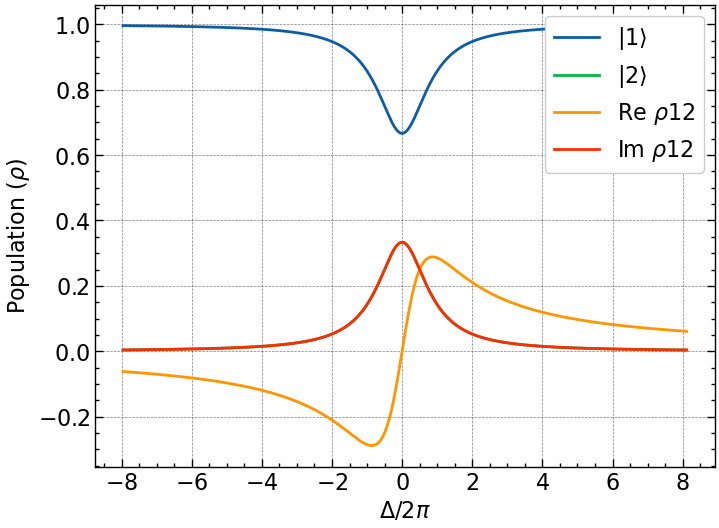

In [4]:
# -- Two Level System Steady State Solution   ##V1##
    
# Rabi frequencies of probe field
Omega = 2 * np.pi * 1

# Radiative decay rate
gamma_1 = 2 * np.pi * 1

# Probe detuning range
d_range = np.arange(-50,51,0.01)    

p1 = l[0](d_range, Omega, gamma_1)
p2 = l[3](d_range, Omega, gamma_1)
coh12 = l[1](d_range, Omega, gamma_1)
coh21 = l[2](d_range, Omega, gamma_1)

pop = p1 + p2  # total populations

rho12 = coh12.imag

# Store the population of imaginary part of coherence 12 to retrieve it from another notebook for comparison.
%store rho12

# ---------- Plotting ----------
plt.style.use(['science', 'notebook', 'grid'])

# Populations
plt.plot(d_range/(2*np.pi), p1.real, label=r"$|1\rangle$")
plt.plot(d_range/(2*np.pi), p2.real, label=r"$|2\rangle$")
plt.plot(d_range/(2*np.pi), coh12.real, label=r"Re $\rho12$")
plt.plot(d_range/(2*np.pi), coh12.imag, label=r"Im $\rho12$")

# Total population
#plt.plot(d_range/(2*np.pi), pop.real, label="Total populations")

plt.xlabel('$\Delta/2\pi$')
plt.ylabel(r'Population ($\rho$)')

plt.legend(loc='upper right')

In [ ]:
# -- Two Level System Steady State Solution  ##V2##

# Rabi frequencies of probe field
Omega = 2 * np.pi * 1

w = (Omega*1j)/2

# Radiative decay rate
gamma1 = 2 * np.pi * 1

# Probe detuning range
d_range = np.arange(-50,51,0.01)    

sol = np.empty((4, len(d_range)), dtype='complex')
for d in range(len(d_range)):
    
    drho = np.array([[0, w, -w, gamma1],                        # p11
                     [0, -w, w, -gamma1],                       # p22
                     [w, -d_range[d]*1j - gamma1/2, 0, -w],     # p12
                     [-w, 0, d_range[d]*1j - gamma1/2, w],      # p21
                     [1, 0, 0, 1]])

    b = np.array([0, 0, 0, 0, 1])

    rho = la.lstsq(drho, b)[0]
    sol[:, d] = rho

pop = sol[0] + sol[3]  # total populations

rho12 = sol[1, :].imag

# Store the population of imaginary part of coherence 12 to retrieve it from another notebook for comparison.
%store rho12

# ---------- Plotting ----------
plt.style.use(['science', 'notebook', 'grid'])

# Populations
plt.plot(d_range/(2*np.pi), sol[0, :].real, label=r"$\rho |1\rangle$")
plt.plot(d_range/(2*np.pi), sol[1, :].imag, label=r"Im $\rho12$")

# Total population
plt.plot(d_range/(2*np.pi), pop.real, label="Total populations")

plt.xlabel('$\Delta/2\pi$')
plt.ylabel(r'Population ($\rho$)')

plt.legend(loc='upper right')

## 2. Numerical Solution

We set Rabi Frequency to $$\Omega_R/2 \pi = 1MHz$$

In [ ]:
# Time array and rabi frequency initialization.

omega_R = 2 * np.pi * 1    # Rabi Fequency 1MHz

t_i = 0
t_f = 5
t = np.arange(t_i, t_f, 0.01)    # (\micro s)

$$\dot{\tilde{c_1}}(t) = \frac{i}{2} \Omega_R \tilde{c_2}(t)$$
$$\dot{\tilde{c_2}}(t) = \frac{i}{2} \Omega_R \tilde{c_1}(t)$$

In [ ]:
##### TESTING ODE SOLVER V1 #######

#def dSdt(t, S):
#    c1, c2 = S
#    return [ (omega_R/2) * c2,
#             (omega_R/2) * c1]

def dSdt(t, S):
    c1, c2 = S
    return [(1j/2).real * omega_R * c2,
            (1j/2).real * omega_R * c1]

c1_0 = 1
c2_0 = 0

S_0 = (c1_0, c2_0)

sol = odeint(dSdt, y0=S_0, t=t, tfirst=True)
#sol = complex_ode(dSdt)

c1_sol = sol.T[0]
c2_sol = sol.T[1]

# Plotting
plt.plot(t, c1_sol, label=r'|g$\rangle$')
plt.plot(t, c2_sol, 'r--', label=r'|e$\rangle$')
plt.xlabel(r"Time [$\mu s$]")
plt.ylabel("Probability Density")
plt.legend(loc='upper right')
################################

$$\ddot{\tilde{c_1}}(t) = -\frac{\Omega_0^2}{4}\tilde{c_1}(t)$$

In [ ]:
##### TESTING ODE SOLVER V2 #######

def dSdt(t, S):  # 2nd order differential equation
    c1, v = S
    return [v, -(omega_R**2/4) * c1]

c1_0 = 1
v_0 = 0

S_0 = (c1_0, v_0)

sol = odeint(dSdt, y0=S_0, t=t, tfirst=True)

c1_sol = sol.T[0]

# Plotting
plt.plot(t, c1_sol, label=r'|g$\rangle$')
plt.xlabel(r"Time [$\mu s$]")
plt.ylabel("Probability Density")
plt.legend(loc='upper right')
################################

## 3. Analytical Solution

$$c_1(t) = \cos(\Omega_R t/2)$$
$$c_2(t) = i\sin(\Omega_R t/2)$$

$$P_2(t) = |c_2(t)|^2 = \frac{\Omega_R^2}{\Omega^2}\sin^2 \left(\frac{\Omega t}{2}\right)$$
where $\Delta = \omega - \omega_0$ is the detuning
$$ \Omega = \sqrt{|\Omega_R|^2 + \Delta^2}$$

In [ ]:
def c1(t, rabi_freq):
    return np.cos((rabi_freq * t) / 2)
def c2(t, rabi_freq):
    return 1j * np.sin((rabi_freq * t) / 2)

g_c = c1(t, omega_R)
e_c = c2(t, omega_R)

#### when field is resonant with the transition, $\Delta = 0$ 

In [ ]:
delta = 0    # detuning
omega = np.sqrt(omega_R**2 + delta**2)

y1 = g_c * np.conj(g_c)    # probability density of ground state
y2 = (omega_R**2 / omega**2) * e_c * np.conj(e_c)    # probability density of excited state

%store y1

# Plotting
plt.plot(t, y1, label=r'|g$\rangle$')
plt.plot(t, y2, 'r--', label=r'|e$\rangle$')
plt.xlabel(r"Time [$\mu s$]")
plt.ylabel("Probability Density")
plt.legend(loc='upper right')

#### when field is not resonant with the transition, $\Delta = \omega - \omega_0 = 0.8\Omega_R$ 

In [ ]:
delta = 0.8 * omega_R    # detuning
omega = np.sqrt(omega_R**2 + delta**2)

y1 = g_c * np.conj(g_c)    # probability density of ground state
y2 = (omega_R**2 / omega**2) * e_c * np.conj(e_c)    # probability density of excited state

# Plotting
plt.plot(t, y1, label=r'|g$\rangle$')
plt.plot(t, y2, 'r--', label=r'|e$\rangle$')
plt.xlabel(r"Time [$\mu s$]")
plt.ylabel("Probability Density")
plt.legend(loc='upper right')

### Damping

$$ |c_2(t)|^2 = \frac{1}{2(1 + 2\zeta^2)}\left[1 - \left(\cos{\Omega' t} + \frac{3\zeta}{(4 - \zeta^2)^{1/2}}\sin{\Omega' t}\right)\exp{\left(-\frac{3\gamma t}{2}\right)}\right] $$

where

$$\zeta = \gamma/\Omega_R$$
$$\Omega' = \Omega_R \sqrt{1 - \zeta^2/4}$$

In [ ]:
# Probability density of excited states in the presence of damping

def c2_damp(t, omega_R, gamma):
    zeta = gamma / omega_R
    omega_prime = omega_R * np.sqrt(1 - (zeta**2 / 4))

    # For easy maintainability we divide expression to three parts
    y2_damp_1 = 1 / (2 * (1 + (2 * zeta**2)))
    y2_damp_2 = np.cos(omega_prime * t) + (3 * zeta)/(np.sqrt(4 - zeta**2)) * np.sin(omega_prime * t)
    y2_damp_3 = np.exp(-(3 * gamma * t)/(2))

    return y2_damp_1 * (1 - y2_damp_2 * y2_damp_3)

gamma1 = omega_R * 0
gamma2 = omega_R * 0.1
gamma3 = omega_R * 1

y2_damp1 = c2_damp(t, omega_R, gamma1)
y2_damp2 = c2_damp(t, omega_R, gamma2)
y2_damp3 = c2_damp(t, omega_R, gamma3)
    
# Plotting
plt.plot(t, y2_damp1, color='tab:blue', label=r'$\gamma/\Omega_R = 0$')
plt.plot(t, y2_damp2, '--', color='tab:red', label=r'$\gamma/\Omega_R = 0.1$')
plt.plot(t, y2_damp3, 'k-.', label=r'$\gamma/\Omega_R = 1$')
plt.xlabel(r"Time [$\mu s$]")
plt.ylabel(r"$|c_2(t)|^2$")
plt.legend(loc='upper right')

## 4. Solution Using Qutip Toolbox

In [ ]:
# ---------------------------------------------
# Two level system solution using Qutip Toolbox
# ---------------------------------------------

omega_R = 2 * np.pi * 1    # Rabi Fequency 1MHz

E_1 = 1
E_2 = 2

t_i = 0
t_f = 5
t = np.arange(t_i, t_f, 0.01)   # (\micro s)

ket_1 = basis(2,0)
ket_2 = basis(2,1)

rho0 = basis(2,0) * basis(2,0).dag()

H_a = (E_1 * ket_1 * ket_1.dag()) + (E_2 * ket_2 * ket_2.dag()) 
H_al = omega_R * (ket_1 * ket_2.dag() + ket_2 * ket_1.dag())
H = H_a + H_al

sol = mesolve(H_al, rho0, t, c_ops=None, e_ops=[ket_1 * ket_1.dag(), ket_2 * ket_2.dag()])

# Plotting
plt.plot(t, sol.expect[0], label=r'|g$\rangle$')
plt.plot(t, sol.expect[1], 'r--', label=r'|e$\rangle$')
plt.xlabel(r"Time [$\mu s$]")
plt.ylabel("Probability Density")
plt.legend(loc='upper right')